# 第14回 機械学習入門

___
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-ueno/begin-python-2025/blob/master/workbook/lecture14.ipynb)

___

## この講義で学ぶこと

前回はデータ分析の手法・考え方について学んだ。
今回はデータに基づいた予測や判断を実現する **機械学習** という技術分野の基礎を紹介する。 

機械学習は、機械（コンピュータ）が膨大な量のデータを学習し、データの中に隠れているパターンやルールを見つけ出し、将来や新しい事象における未知のデータについての予測や判断を行う技術分野である。
前回、データサイエンスではデータ収集、データクリーニング、データ分析、モデル作成、予測と解釈という一連のプロセスがあり、その中のデータ分析について学んだ。今回の内容はその後のモデル作成と予測の部分に相当する。 

機械学習には以下の3種類がある。今回はこれらのうちの **教師あり学習** を取り上げ、分類問題、回帰問題における機械学習モデルの構築とそれを用いた予測の方法について学んでいく。

1. 教師あり学習: 入力とそれに対応する出力を学習させる手法
2. 教師なし学習: 「正解」ラベルを含めないデータにより学習させる手法
3. 強化学習: 「正解」を与える代わりに将来の価値を最大化するためにとる行動を決定する手法


## 準備

まずは、前回と同様に `japanize_matplotlib` のインストール、および必要なライブラリのインポートを行う。

In [1]:
pip install japanize_matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
plt.rcParams.update({'font.size': 14})  # 文字サイズを14pxとする

今回も、前回・前々回で利用したダイヤモンドのデータを利用する。

In [3]:
df = sns.load_dataset('diamonds')
print(df.shape)
df

(53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## 教師あり学習

教師あり学習は、入力とそれに対応する出力を学習させる手法である。学習データには「正解」ラベルが付与されており、「正解」が付与されるデータとそれ以外のデータ各々の特徴を識別し、「正解」そのものまたはそれに近いデータを出力するようにしていく。
入力のことを **説明変数** (`X`で表す)、出力のことを **目的変数** (`y`で表す)と呼ぶ。


### 分類問題


分類問題とは、予測したい目的変数が離散的な値（カテゴリ）であり、説明変数が表す対象のカテゴリを予測する問題である。
例えば入力された画像が犬か猫（またはそれ以外）かを予測する問題は分類問題である。

ここで、ダイヤモンドのデータのカット `cut` の値を他の変数から予測する分類問題を考えてみる。 

説明変数 `X`は ダイヤモンドデータから`drop()`メソッドで `cut`列を除去したものを、目的変数 `y`は `cut`列のみ抽出したものをそれぞれ代入する。

In [4]:
X = df.drop(["cut"], axis=1)
y = df["cut"]

機械学習モデルを構築するにあたり、データを学習用とテスト用の2つに分割する。モデルの学習には学習用データのみを用い、それにより構築されたモデルの予測精度を検証するのにテスト用データを用いる。このようにする理由は、予測させたいデータが学習用データに含まれていると「正解」を知っているも同然となり、予測精度が不当に高くなってしまうためである。本来得られるはずのないデータを学習の際に用いることを **データリーケージ (リーク)** と呼ぶ。 `scikit-learn` ライブラリの `train_test_split()` 関数を用いて `X`, `y`を学習用データ `X_train`, `y_train`とテストデータ `X_test`, `y_test`に分割して各々を用いて学習、テストすることでリークを防ぐことができる。学習用・テスト用にデータを分割してモデルを構築・検証する方法を **ホールドアウト法 (hold-out)** と呼ぶ。

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40455, 9)
(13485, 9)
(40455,)
(13485,)


分類問題を解く機械学習アルゴリズムには様々なものがあるが、ここでは `scikit-learn`の提供する、ランダムフォレスト (Random forest)というアルゴリズムによる分類モデル `RandomForestClassifier` を学習させることにする。
モデルを学習させるメソッド `fit()`を用いて学習を行う。引数には 説明変数 `X`, 目的変数 `y`を指定する。 `fit(X, y)`という形はモデルの学習を行うメソッドとして慣習的に用いられるため、これを知っておくと新しいモデルを利用する際のソースコードの理解に役に立つ。
ちなみに、学習済みモデルで予測を実行する際は `predict(X)` という形のメソッドが用いられる。

これによりモデルの構築が行われると期待するところである。ところが、以下のセルを実行してみるとエラーが発生してしまう。

In [6]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'G'

このエラーの原因は、説明変数の中に文字列で表されるカテゴリ値が含まれていることである。機械学習モデル構築の際には、このようにデータをそのままの形では入力できないことがかなり頻繁に発生する。 
このエラーに対処する方法の一つとして、モデルに入力する前にカテゴリ値を数値に変換するような **前処理** を行うことが挙げられる。`scikit-learn`の`OrdinalEncoder`は、「カテゴリ値を数値に変換する」という前処理を行う部品として使えるものである。
前処理部品の `fit()` メソッドにより、データに適合した前処理を行うようにフィットされ、 `transform()`メソッドにより実際にデータに前処理を行う。これらを一度に行うメソッドとして `fit_transform()`もあり、ここではそれを用いることにする。
`fit_transform()`メソッドの引数には前処理したい変数名 (列の名前)を指定する。ここでは、説明変数 `X` の全ての変数を変換するため、以下のように行う

`OrdinalEncoder`により `color` 等のカテゴリ値が全て数値に変換されていることが確認できる。


In [7]:
cols = ["color", "clarity"]
oe = OrdinalEncoder()
X[cols] = oe.fit_transform(X[cols])
X

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,1.0,3.0,61.5,55.0,326,3.95,3.98,2.43
1,0.21,1.0,2.0,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1.0,4.0,56.9,65.0,327,4.05,4.07,2.31
3,0.29,5.0,5.0,62.4,58.0,334,4.20,4.23,2.63
4,0.31,6.0,3.0,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,0.0,2.0,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,0.0,2.0,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,0.0,2.0,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,4.0,3.0,61.0,58.0,2757,6.15,6.12,3.74


さて、前処理された説明変数 `X`を再び用いてモデルの学習を行っていく。今度はエラーが発生せず無事完了するはずである。モデルの学習には若干時間がかかるため、完了するまでしばらく待つ必要がある。

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

これにより学習済みモデル `model` を得ることができた。 `model`とテスト用データ `X_test`を用いて予測を実行してみよう。

In [9]:
y_pred = model.predict(X_test)

分類モデルを評価するための指標にもいくつか存在するが、ここでは最も基本的な、「正解」を得ることが出来た割合を表す `Accuracy` (正解率)を用いることにする。 高いほど良く、`1.0`が最良である。

In [10]:

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7845754542083797


### 回帰問題

次に、回帰問題を見ていく。 

回帰問題は、予測したい目的変数が数値であり、説明変数から「正解」に対してなるべく近い値を予測する問題である。分類問題と同様、回帰問題を解く機械学習アルゴリズムは様々なものがあるが、ここでは先ほどの例と同じランダムフォレストを用いた機械学習モデル `RandomForestRegressor`を学習させてみる。コードは分類問題のものとほぼ同等で、目的変数とモデルの名前のみ異なる。 

ここで、ダイヤモンドの価格 `price` を他の変数から予測する回帰問題を考えてみる。 

In [11]:
X = df.drop(["price"], axis= 1)
y = df["price"]

cols = ["cut", "color", "clarity"]
oe = OrdinalEncoder()
X[cols] = oe.fit_transform(X[cols])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

回帰モデルを評価する指標として $R^2$ (coefficient of determination) や Mean Absolute Error (MAE)等がある。 $R^2$は高いほど良く、`1.0`が最良である。MAEは低いほど良く、`0`が最良である。

In [12]:
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

R2 Score: 0.9809750222280644
Mean Absolute Error: 272.3392734302076


正解値と予測値がどれほど近いか散布図にプロットして可視化してみよう。

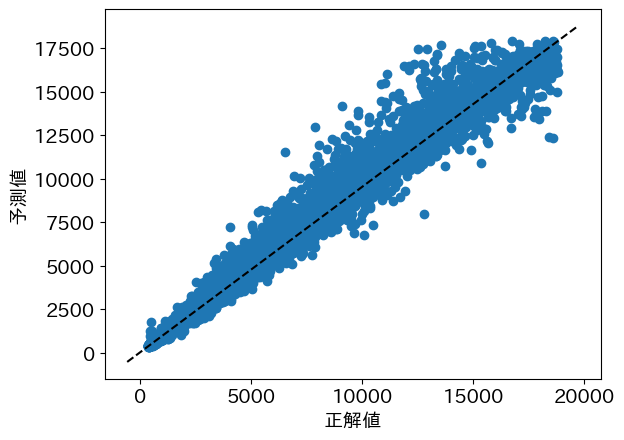

In [13]:
plt.scatter(y_test, y_pred)
plt.xlabel("正解値")
plt.ylabel("予測値")
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.plot(x_lim, y_lim, "k--")
plt.show()

## 演習

**課題1**  
ダイヤモンドデータに新しい変数 `is_expensive`を追加し、`is_expensive`を予測する分類モデルを構築しなさい。ただし、 `is_expensive`は `price`の値が `1000`より大きいとき `True`、`1000` 以下のとき `False`となるブール値とする。また、`price` が説明変数に含まれるとリークにあたるため説明変数から除去する必要がある。以下のコードの「ここに適切なコードを書く」に続けて適切なコードを記述してみよう。

In [ ]:
df2 = df.copy()

# カテゴリ値を数値に変換する
cols = ["cut", "color", "clarity"]
oe = OrdinalEncoder()
df2[cols] = oe.fit_transform(df2[cols])

# ここに適切なコードを書く


# X, yを学習用・テスト用に分割する
X_train, X_test, y_train, y_test = train_test_split(X, y)

# ここに適切なコードを書く


y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))